/Users/Magali/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/Magali/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/Magali/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/Magali/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


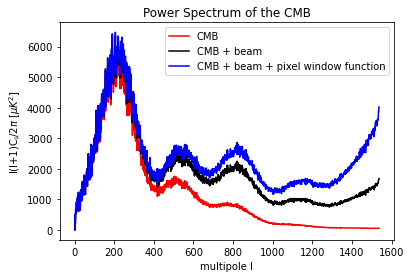

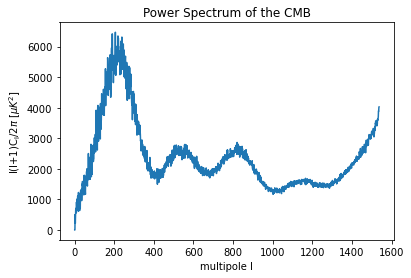

In [1]:
import healpy as hp
import numpy as np
import math
from  matplotlib import pyplot as plt


# Power spectrum of the CMB
CMB_map = hp.read_map('./CMB_map_mask') # the best CMB map with the mask
power_spectrum = hp.sphtfunc.anafast(CMB_map) # Cl_CMB(measured)


# Power spectrum of the beam
sigma = (9.68 * math.pi/(60*180)) / 2.35 # sigma of the gaussian (sigma = 2.35*fwhm where fwhm=9.68 is the angular resolution)
Cl_beam = [np.exp(- l**2 * sigma**2) for l in range(1, np.shape(power_spectrum)[0]+1)] # l multipole


# Power spectrum of the pixel window function
pixel_window_function = hp.sphtfunc.pixwin(512) # pixel window function for Nside = 512 # Cl_pixel


# Power spectrum of the CMB
f_sky = 0.60 # fraction of the covered sky (no mask)
Cl_CMB = power_spectrum / (Cl_beam * pixel_window_function**2 * f_sky)
CMB_beam = power_spectrum / (np.array(Cl_beam) * f_sky)


# Plot of the power spectrum
x = [i for i in range(1, np.shape(power_spectrum)[0]+1)]
y =            [l*(l+1)*power_spectrum[l]*1e12 /f_sky /(2*math.pi) for l in range(np.shape(power_spectrum)[0])]
y_beam =       [i*(i+1)*CMB_beam[i]*1e12 /(2*math.pi) for i in range(np.shape(power_spectrum)[0])]
y_beam_pixel = [i*(i+1)*Cl_CMB[i]*1e12 /(2*math.pi) for i in range(np.shape(power_spectrum)[0])]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.title('Power Spectrum of the CMB')
plt.xlabel('multipole l')
plt.ylabel('l(l+1)$\\mathrm{C_l}$/${2\pi}$ [$\mu K^2$]')
plt.plot(x,y, 'r', label='CMB')                                           # CMB
plt.plot(x,y_beam, 'k', label='CMB + beam')                               # CMB + beam
plt.plot(x,y_beam_pixel, 'b', label='CMB + beam + pixel window function') # CMB + beam + pixel window function
plt.legend()
plt.show()


# Plot of the power spectrum alone
x = [i for i in range(1, np.shape(power_spectrum)[0]+1)]
y = [i*(i+1)*Cl_CMB[i]*1e12 /(2*math.pi) for i in range(np.shape(power_spectrum)[0])]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.title('Power Spectrum of the CMB')
plt.xlabel('multipole l')
plt.ylabel('l(l+1)$\\mathrm{C_l}$/${2\pi}$ [$\mu K^2$]')
plt.plot(x,y)
plt.show()

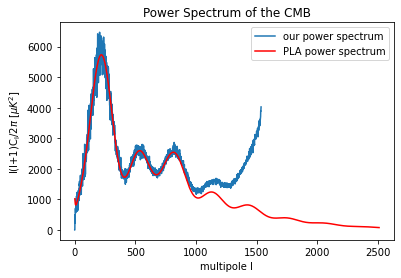

In [2]:
# Comparing our CMB power spectrum with the one of the Plank Legacy Archive

PLA_best_PS = np.loadtxt("COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt")
plt.title('Power Spectrum of the CMB')
plt.xlabel('multipole l')
plt.ylabel('l(l+1)$\\mathrm{C_l}$/${2\pi}$ [$\mu K^2$]')
plt.plot(x,y_beam_pixel, label='our power spectrum')
plt.plot(PLA_best_PS[:,0],PLA_best_PS[:,1], color='r', label='PLA power spectrum')
plt.legend()
plt.show()

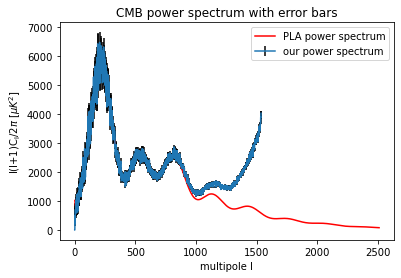

In [3]:
# Error bars

delta_Cl = [math.sqrt(2/(2*l+1)*f_sky)*y_beam_pixel[l] for l in range(len(y_beam_pixel))]

plt.errorbar(x,y_beam_pixel, yerr=delta_Cl, ecolor='k', label='our power spectrum')
plt.title('CMB power spectrum with error bars')
plt.plot(PLA_best_PS[:,0],PLA_best_PS[:,1], color='r', label='PLA power spectrum')
plt.xlabel('multipole l')
plt.ylabel('l(l+1)$\\mathrm{C_l}$/${2\pi}$ [$\mu K^2$]')
plt.legend()
plt.show()

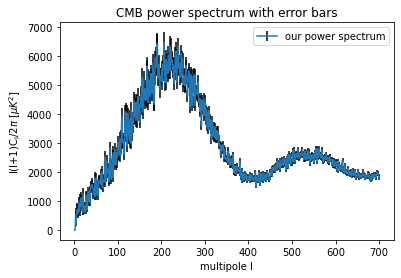

In [4]:
# Error bars

cut_y_beam_pixel = y_beam_pixel[:700]
cut_delta_Cl = [math.sqrt(2/(2*l+1)*f_sky)*y_beam_pixel[l] for l in range(len(cut_y_beam_pixel))]
cut_x = x = [i for i in range(1, len(cut_y_beam_pixel)+1)]

plt.errorbar(x,cut_y_beam_pixel, yerr=cut_delta_Cl, ecolor='k', label='our power spectrum')
plt.title('CMB power spectrum with error bars')
plt.xlabel('multipole l')
plt.ylabel('l(l+1)$\\mathrm{C_l}$/${2\pi}$ [$\mu K^2$]')
plt.legend()
plt.show()

In [5]:
import camb
from camb import model, initialpower

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.27, ombh2=0.02236, omch2=0.1200, mnu=0.06, omk=0, tau=0.0544)
pars.InitPower.set_params(As=2.1e-9, ns=0.9649, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

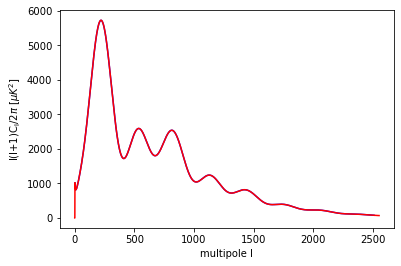

In [6]:
# Test of the fixed cosmological parameters

totalCL = powers['total']

plt.plot(PLA_best_PS[:,0],PLA_best_PS[:,1], color='b')
plt.plot(totalCL[:,0], color='r')
plt.xlabel('multipole l')
plt.ylabel('l(l+1)$\\mathrm{C_l}$/${2\pi}$ [$\mu K^2$]')
plt.show()

In [7]:
# Test of H0 with a power spectrum that stops at l=700 (stop before the noise increases the power spectrum)

chi_squared_H0 = []
H0 = [66.6+0.01*i for i in range(108)]

for i in range(len(H0)):
    chi_squared_H0.append(0)
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0[i], ombh2=0.02236, omch2=0.1200, mnu=0.06, omk=0, tau=0.0544)
    pars.InitPower.set_params(As=2.1e-9, ns=0.9649, r=0)
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    
    unlensedCL = powers['unlensed_scalar']
    totalCL = powers['total']
    
    for l in range(1,700):
        chi_squared_H0[i] += ((y_beam_pixel[l]-totalCL[l,0])/delta_Cl[l])**2/700

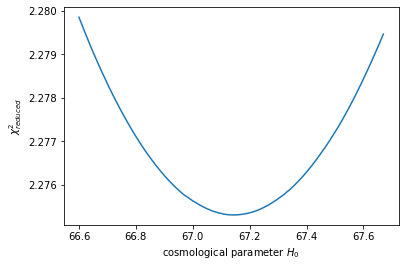

In [8]:
# Plot of chi_squared as a function of H0

x_H0 = H0
y_H0 = chi_squared_H0
plt.plot(x_H0,y_H0)
plt.xlabel('cosmological parameter $H_{0}$')
plt.ylabel('$\chi_{reduced}^{2}$')
plt.show()

In [9]:
# Best value of H0

min_H0 = 100
min_place_H0 = -1

for i in range(len(chi_squared_H0)):
    if chi_squared_H0[i] < min_H0 :
        min_H0 = chi_squared_H0[i]
        min_place_H0 = i

print('the min value of sigma is', chi_squared_H0[min_place_H0])
print('the value of H0 is', H0[min_place_H0])

the min value of sigma is 2.2753035047847443
the value of H0 is 67.14


In [10]:
# Error bars of H0

chi_squared_H0_normal = [chi_squared_H0[i]*700 for i in range(len(chi_squared_H0))] # use of the normal chi squared, not the reduced one
chi_squared_H0_error = chi_squared_H0_normal[min_place_H0] +1 # 1 sigma error, 68,27% error

min_place_H0_error = 1000

for i in range(len(chi_squared_H0_normal)):
    if chi_squared_H0_normal[i] < chi_squared_H0_error :
        min_place_H0_error = i
        break
        
print('the min value of H0 is', H0[min_place_H0_error])


max_place_H0_error = 1000

for j in range(len(chi_squared_H0_normal)):
    if chi_squared_H0_normal[len(chi_squared_H0_normal)-1-j] < chi_squared_H0_error :
        max_place_H0_error = len(chi_squared_H0_normal)-j
        break

print('the max value of H0 is', H0[max_place_H0_error])

print('\nthe value of H0 is', H0[min_place_H0], '+-', (H0[max_place_H0_error]-H0[min_place_H0_error])/2)

the min value of H0 is 66.83999999999999
the max value of H0 is 67.46

the value of H0 is 67.14 +- 0.3100000000000023


In [11]:
# Test of Omega_b*h^2

chi_squared_ombh2 = []
ombh2 = [0.0215+0.00001*i for i in range(30)]

for i in range(len(ombh2)):
    chi_squared_ombh2.append(0)
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.27, ombh2=ombh2[i], omch2=0.1200, mnu=0.06, omk=0, tau=0.0544)
    pars.InitPower.set_params(As=2.1e-9, ns=0.9649, r=0)
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    
    unlensedCL = powers['unlensed_scalar']
    totalCL = powers['total']
    
    for l in range(1, 700):
        chi_squared_ombh2[i] += ((y_beam_pixel[l]-totalCL[l,0])/delta_Cl[l])**2/700

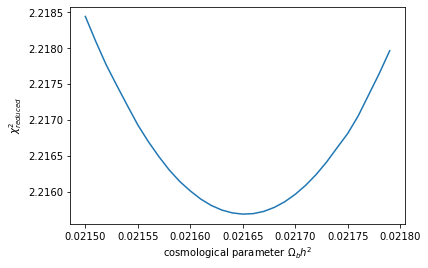

In [12]:
# Plot of chi_squared as a function of Omega_b*h^2

x_ombh2 = ombh2
y_ombh2 = chi_squared_ombh2
plt.plot(x_ombh2,y_ombh2)
plt.xlabel('cosmological parameter $\Omega_{b}h^{2}$')
plt.ylabel('$\chi_{reduced}^{2}$')
plt.show()

In [13]:
# Best value of ombh2

min_ombh2 = 100
min_place_ombh2 = -1

for i in range(len(chi_squared_ombh2)):
    if chi_squared_ombh2[i] < min_ombh2 :
        min_ombh2 = chi_squared_ombh2[i]
        min_place_ombh2 = i

print('the min value of sigma is', chi_squared_ombh2[min_place_ombh2])
print('the value of ombh2 is', ombh2[min_place_ombh2])

h = H0[min_place_H0] / 100
omb = ombh2[min_place_ombh2]*h**2
print('the value of omb is', omb)

the min value of sigma is 2.2156868353519568
the value of ombh2 is 0.02165
the value of omb is 0.009759342833999998


In [14]:
# Error bars of ombh2

chi_squared_ombh2_normal = [chi_squared_ombh2[i]*700 for i in range(len(chi_squared_ombh2))] # use of the normal chi squared, not the reduced one
chi_squared_ombh2_error = chi_squared_ombh2_normal[min_place_ombh2] +1 # 1 sigma error, 68,27% error

min_place_ombh2_error = 1000

for i in range(len(chi_squared_ombh2_normal)):
    if chi_squared_ombh2_normal[i] < chi_squared_ombh2_error :
        min_place_ombh2_error = i
        break
        
print('the min value of ombh2 is', ombh2[min_place_ombh2_error])

max_place_ombh2_error = 1000

for j in range(len(chi_squared_ombh2_normal)):
    if chi_squared_ombh2_normal[len(chi_squared_ombh2_normal)-1-j] < chi_squared_ombh2_error :
        max_place_ombh2_error = len(chi_squared_ombh2_normal)-j
        break
        
print('the max value of ombh2 is', ombh2[max_place_ombh2_error])

print('\nthe value of ombh2 is', ombh2[min_place_ombh2], '+-', (ombh2[max_place_ombh2_error]-ombh2[min_place_ombh2_error])/2)

the min value of ombh2 is 0.02155
the max value of ombh2 is 0.021769999999999998

the value of ombh2 is 0.02165 +- 0.00010999999999999899
